# imports

In [20]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import seaborn as sns
import pandas as pd
import json
from matplotlib import pyplot as plt
from model import *
from plot_utils import *

In [21]:
AGENT_COUNT = 248
EXPERIMENT_STEPS = 200_000
PERFORM_RUN = False
PERFORM_BUS_EXPERIMENTS = False
PERFORM_TOLL_EXPERIMENTS = False
DO_SHOW_PLOTS_IN_NOTEBOOK = True

In [22]:
if DO_SHOW_PLOTS_IN_NOTEBOOK:
    plt.ion()
else:
    plt.ioff()

### Functions for saving and loading results

In [23]:
def savexperiment_results(dataframe: pd.DataFrame, filename: str):
    dataframe.to_csv(filename)


def load_results(filename: str) -> pd.DataFrame:
    return pd.read_csv(filename, index_col=0)


def get_agent_histories(agents) -> list:
    return [agent.history for agent in agents]


def save_agent_histories(agents, filename: str):
    histories = get_agent_histories(agents)
    with open(filename, "w") as f:
        json.dump(histories, f)


def load_agent_histories(filename: str):
    with open(filename, "r") as f:
        return json.load(f)


def save_model(model, model_name: str):
    model_results = model.datacollector.get_model_vars_dataframe()
    model_agents = model.schedule.agents
    savexperiment_results(model_results, f"{model_name}_results.csv")
    save_agent_histories(model_agents, f"{model_name}_histories.json")


def load_model(model_name: str):
    return load_results(f"{model_name}_results.csv"), load_agent_histories(f"{model_name}_histories.json")

# Run the 4-link and 5-link models
save the results for later use

In [24]:
if PERFORM_RUN:
    model_4link = Model_4link(AGENT_COUNT)
    model_4link.initialize_agents_positions()

    model_5link = Model_5link(AGENT_COUNT)
    model_5link.initialize_agents_positions()

    for _ in range(EXPERIMENT_STEPS):
        model_4link.step()
        model_5link.step()

    save_model(model_4link, "model_4link")
    save_model(model_5link, "model_5link")

In [25]:
model_4link_results, model_4link_histories = load_model("model_4link")
model_5link_results, model_5link_histories = load_model("model_5link")

# Data analysis and visualization

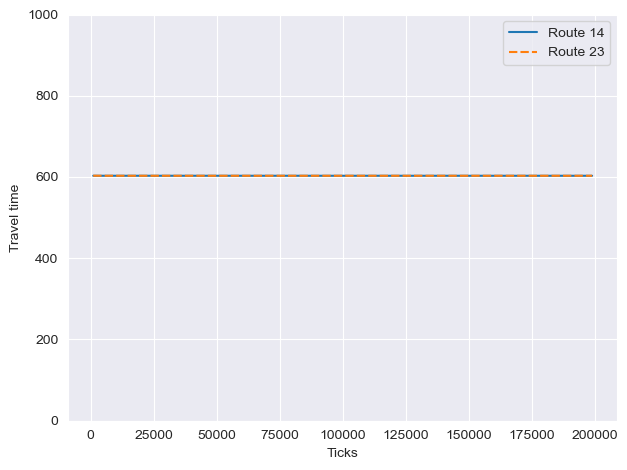

In [26]:
plot_travel_times(model_4link_results, "model_4link")

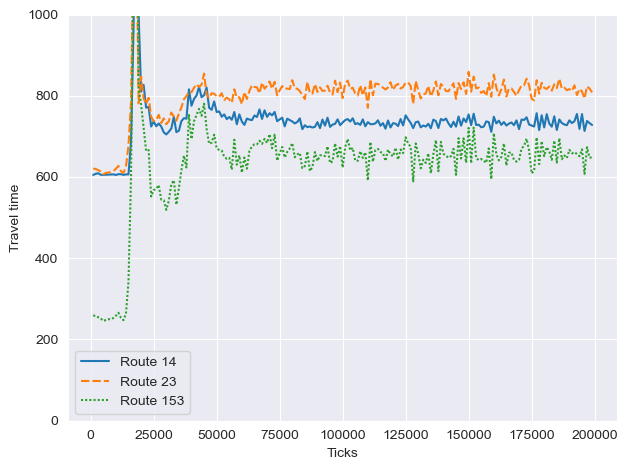

In [27]:
plot_travel_times(model_5link_results, "model_5link")

## Find the final average travel times per route, as remembered by the agents
(for each agent, check their 30 round history, save the average travel time per route)

In [28]:
final_average_travel_times(model_4link_histories)

Total occurrences:  {'R23': 3476, 'R14': 3964}
Averages:  {'R23': 603, 'R14': 603}


{'R23': 603, 'R14': 603}

In [29]:
final_average_travel_times(model_5link_histories)

Total occurrences:  {'R153': 5226, 'R14': 1871, 'R23': 343}
Averages:  {'R153': 658, 'R14': 736, 'R23': 818}


{'R153': 658, 'R14': 736, 'R23': 818}

From these averages can be seen that for the 5-link system, everyone is worse off. Thus, in this case, adding the road gives rise to Braess paradox

In [30]:
interpret_agent_strategies(model_4link_histories)

we found that
 - 197 agents took route R14 and R23
 - 23 agents took route R23
 - 28 agents took route R14
in their last 30 passes through the network


In [31]:
interpret_agent_strategies(model_5link_histories)

we found that
 - 181 agents took route R14 and R153 and R23
 - 65 agents took route R14 and R153
 - 2 agents took route R153 and R23
in their last 30 passes through the network


# Plot the throughput of each route during training
throughput is plotted as the average number of cars that pass through a route per 1000 ticks, averaged over 3000 ticks 

,Route 14,Route 23,Total throughput
2,200.000000,212.333333,412.333333
3,197.333333,212.666667,410.000000
4,202.333333,207.333333,409.666667
5,210.000000,203.333333,413.333333
6,205.000000,205.000000,410.000000
...,...,...,...
194,221.333333,192.000000,413.333333
195,216.666667,193.333333,410.000000
196,217.000000,193.000000,410.000000
197,219.666667,193.666667,413.333333


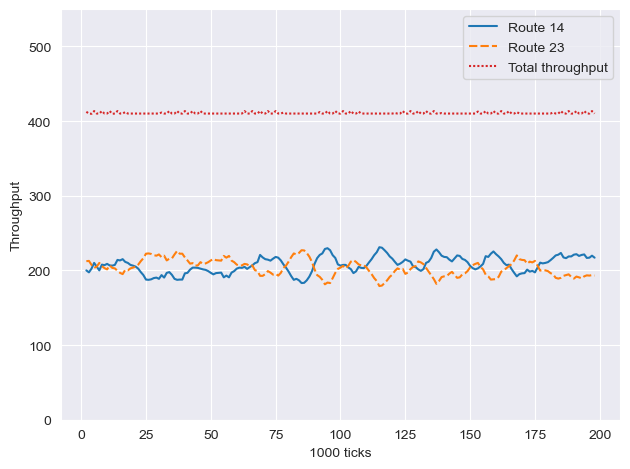

In [32]:
plot_throughput(model_4link_results, "model_4link")

,Route 14,Route 23,Route 153,Total throughput
2,162.333333,172.666667,168.333333,503.333333
3,168.333333,161.000000,174.333333,503.666667
4,176.333333,162.000000,168.666667,507.000000
5,169.000000,166.666667,170.333333,506.000000
6,164.333333,173.333333,170.333333,508.000000
...,...,...,...,...
194,88.000000,19.000000,258.666667,365.666667
195,86.000000,20.333333,256.000000,362.333333
196,88.666667,19.000000,260.333333,368.000000
197,92.000000,18.000000,254.333333,364.333333


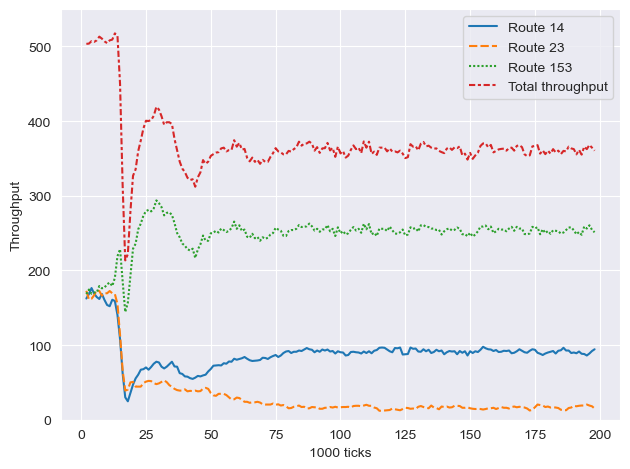

In [33]:
plot_throughput(model_5link_results, "model_5link")

In [34]:
model_histories = [model_4link_histories, model_5link_histories]
model_names = ["4-link", "5-link"]
create_latex_table(model_histories, model_names)

          &    4-link     &    5-link     
Route 14  &  603  & 0.533 &  736  & 0.251  \\
Route 23  &  603  & 0.467 &  818  & 0.046  \\
Route 153 & -  &   -   &  658  & 0.702  \\
          &     603.0     &     685.1     


# Bus lane experiments


# Experiment 1 - replace cars by busses in the 5 link model
Busses can only take route 153, cars are not allowed to take the buslane (route 153 )

In [35]:
import os


def save_experiments(models: list[Model_5link_with_bus], model_names: list[str], folder_name: str):
    os.makedirs(folder_name, exist_ok=True)

    for i, model in enumerate(models):
        model_name = model_names[i]
        save_model(model, f"{folder_name}/{model_name}")


def load_experiments(folder_name: str):
    models = {}

    for file_name in os.listdir(folder_name):
        model_name = file_name.split("_")[0]
        if model_name not in models.keys():
            models[model_name] = load_model(f"{folder_name}/{model_name}")

    models = {k: v for k, v in sorted(models.items(), key=lambda item: float(item[0].split('=')[1]))}
    print("loaded models")
    return models


def save_bus_experiments(models: list[Model_5link_with_bus], model_names: list[str]):
    return save_experiments(models, model_names, "bus_experiments")


def load_bus_experiments():
    return load_experiments("bus_experiments")


def save_toll_experiments(models: list[Model_5link_with_bus], model_names: list[str]):
    return save_experiments(models, model_names, "toll_experiments")


def load_toll_experiments(subtract_toll=True):
    experiment_data = load_experiments("toll_experiments")
    if subtract_toll:
        for experiment_name, experiment_results in experiment_data.items():
            model_results, model_histories = experiment_results
            toll = experiment_name.split("=")[1]
            adjusted_histories = [
                [[route, time] if route != "R153" else [route, time - int(toll)]  for route, time in agent_history]
                for agent_history in model_histories
            ]
            experiment_data[experiment_name] = (model_results, adjusted_histories)
    return experiment_data


In [36]:
def analyse_experiment(experiment_data, folder_name: str):
    """
    for each model:
     - plot travel times and throughput
     - collect final throughput
     - collect final average travel times
     - 
     
    """
    experiment_throughputs = {}
    travel_times = []

    for model_name, experiment_results in experiment_data.items():
        print(model_name)
        model_results, model_histories = experiment_results
        
        # plot travel times and throughput        
        plot_travel_times(model_results, f"{folder_name}/{model_name}")
        model_throughput = plot_throughput(model_results, f"{folder_name}/{model_name}")
        
        # collect avg throughput of last 1000 ticks/sweeps
        final_throughput = model_throughput.iloc[-1]["Total throughput"]
        experiment_throughputs[model_name] = round(final_throughput)

        interpret_agent_strategies(model_histories)
        print()
        travel_times.append(final_average_travel_times(model_histories))
        print()
    
    print(travel_times)

    model_histories = [experiment_results[1] for experiment_results in experiment_data.values()]
    model_names = experiment_data.keys()
    
    model_names = [model_name.split('=')[1] for model_name in model_names]
    if folder_name == "bus_experiments":
        model_names = [int(float(name) * AGENT_COUNT) for name in model_names]
    elif folder_name == "toll_experiments":
        model_names = [int(name) for name in model_names]
    create_latex_table(model_histories, model_names)
    
    plt.figure()
    plt.plot(list(experiment_throughputs.keys()), list(experiment_throughputs.values()))
    # plt.show()
    
    print()


def analyse_bus_experiments():
    analyse_experiment(load_bus_experiments(), "bus_experiments")


def analyse_toll_experiments():
    analyse_experiment(load_toll_experiments(), "toll_experiments")

In [37]:
bus_ratios = list(range(5, 30, 5))

for x in bus_ratios:
    ratio = x / 100
    n_bus = int(ratio * AGENT_COUNT)
    n_car = AGENT_COUNT - n_bus
    print(f"ratio: {ratio}. n_bus: {int(ratio * AGENT_COUNT)}. n_car: {n_car}")

    if PERFORM_BUS_EXPERIMENTS:
        bus_model = Model_5link_with_bus(n_car, n_bus)
        bus_model.initialize_agents_positions()

        for _ in range(EXPERIMENT_STEPS):
            bus_model.step()

        save_bus_experiments([bus_model], [f"{ratio=}"])

ratio: 0.05. n_bus: 12. n_car: 236
ratio: 0.1. n_bus: 24. n_car: 224
ratio: 0.15. n_bus: 37. n_car: 211
ratio: 0.2. n_bus: 49. n_car: 199
ratio: 0.25. n_bus: 62. n_car: 186


loaded models
ratio=0.05
we found that
 - 186 agents took route R14 and R23
 - 19 agents took route R14
 - 31 agents took route R23
 - 12 agents took route R153
in their last 30 passes through the network

Total occurrences:  {'R14': 3125, 'R23': 3955, 'R153': 360}
Averages:  {'R14': 603, 'R23': 604, 'R153': 242}

ratio=0.1
we found that
 - 177 agents took route R14 and R23
 - 16 agents took route R14
 - 31 agents took route R23
 - 24 agents took route R153
in their last 30 passes through the network

Total occurrences:  {'R23': 3746, 'R14': 2974, 'R153': 720}
Averages:  {'R23': 603, 'R14': 603, 'R153': 242}

ratio=0.15
we found that
 - 13 agents took route R14
 - 12 agents took route R23
 - 186 agents took route R14 and R23
 - 37 agents took route R153
in their last 30 passes through the network

Total occurrences:  {'R14': 2874, 'R23': 3456, 'R153': 1110}
Averages:  {'R14': 604, 'R23': 605, 'R153': 243}

ratio=0.2
we found that
 - 177 agents took route R14 and R23
 - 17 agents took r

/Users/rickhuizing/PycharmProjects/DMAS/dmas_braess/plot_utils.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


we found that
 - 97 agents took route R14 and R23
 - 13 agents took route R23
 - 2 agents took route R14
 - 136 agents took route R153
in their last 30 passes through the network

Total occurrences:  {'R14': 1258, 'R23': 2102, 'R153': 4080}
Averages:  {'R14': 647, 'R23': 647, 'R153': 413}

ratio=0.6
we found that
 - 27 agents took route R23
 - 73 agents took route R14 and R23
 - 148 agents took route R153
in their last 30 passes through the network

Total occurrences:  {'R23': 2879, 'R14': 121, 'R153': 4440}
Averages:  {'R23': 641, 'R14': 738, 'R153': 459}

ratio=0.65
we found that
 - 60 agents took route R14 and R23
 - 27 agents took route R23
 - 161 agents took route R153
in their last 30 passes through the network

Total occurrences:  {'R23': 2498, 'R14': 112, 'R153': 4830}
Averages:  {'R23': 736, 'R14': 811, 'R153': 627}

ratio=0.7
we found that
 - 55 agents took route R14 and R23
 - 20 agents took route R23
 - 173 agents took route R153
in their last 30 passes through the network


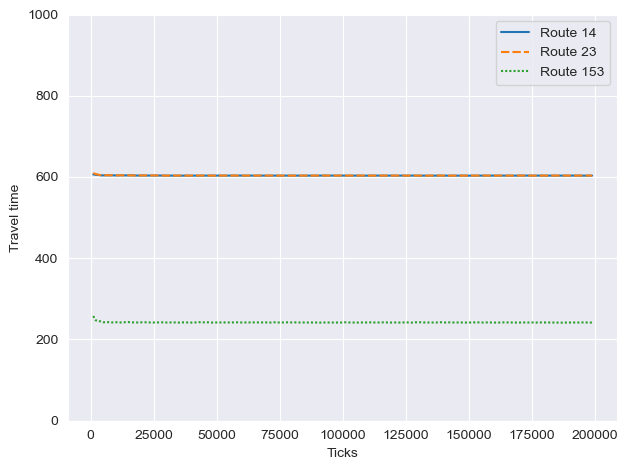

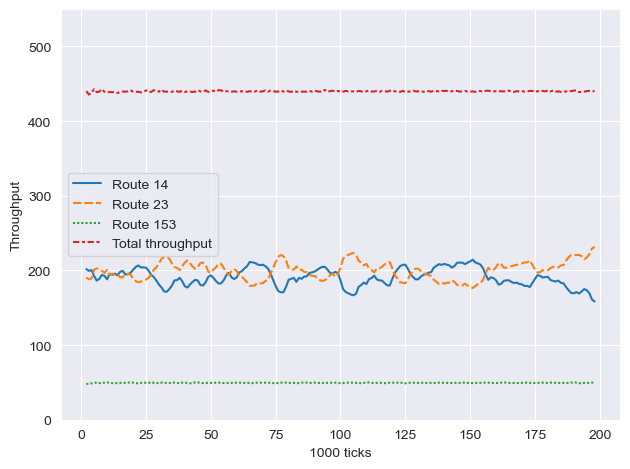

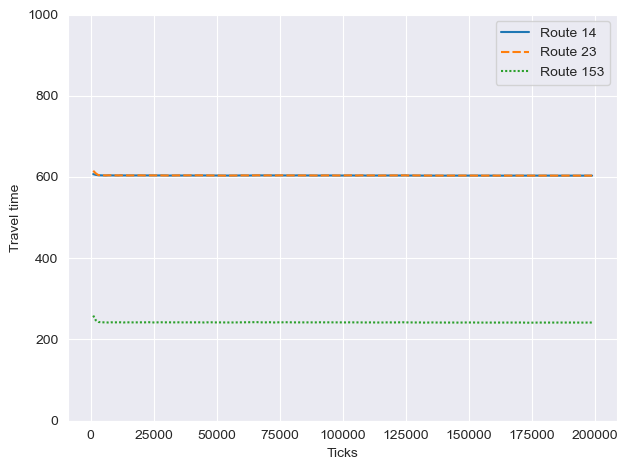

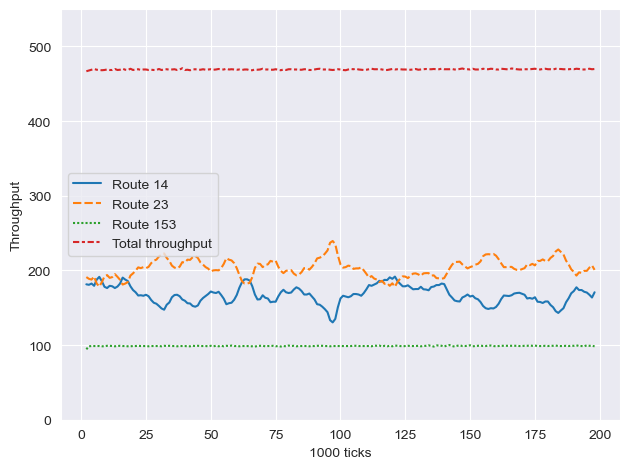

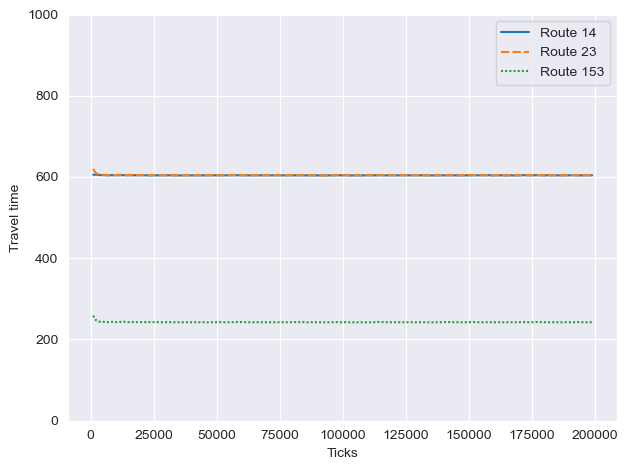

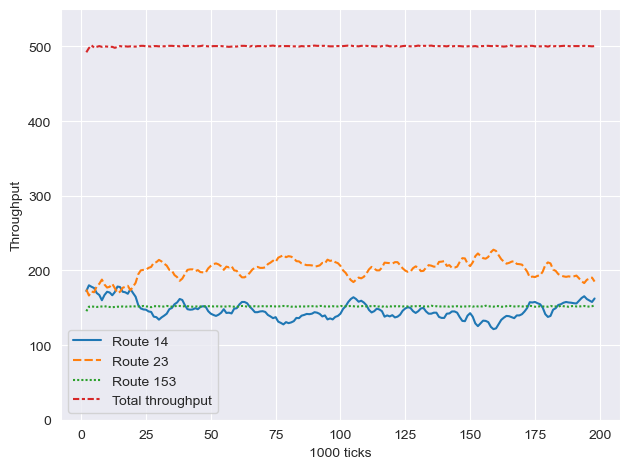

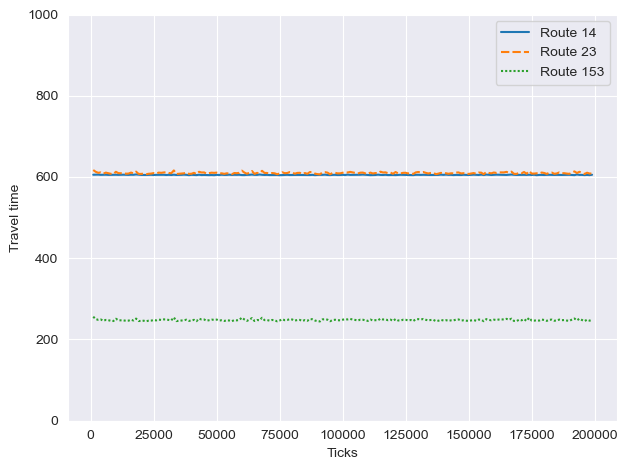

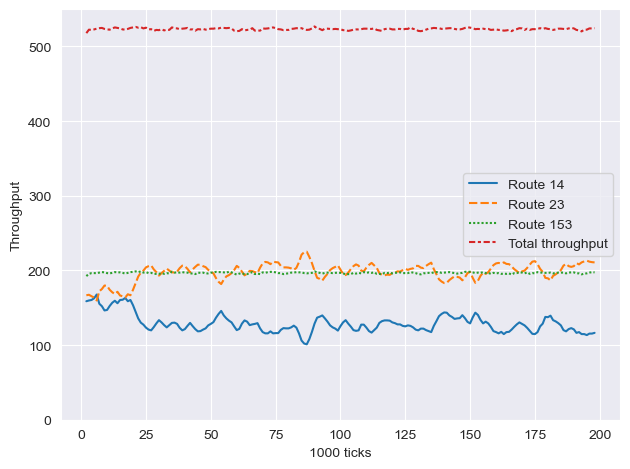

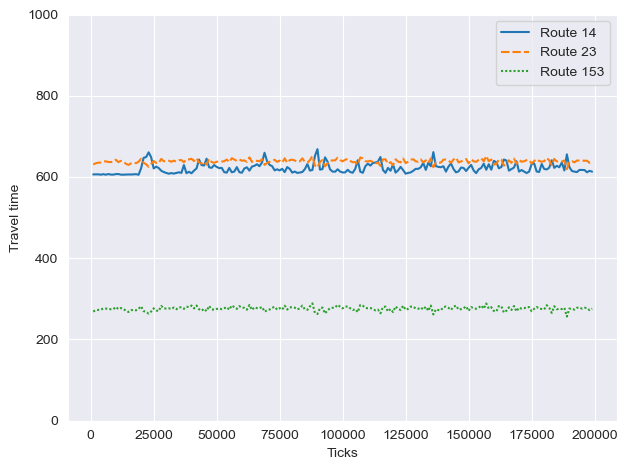

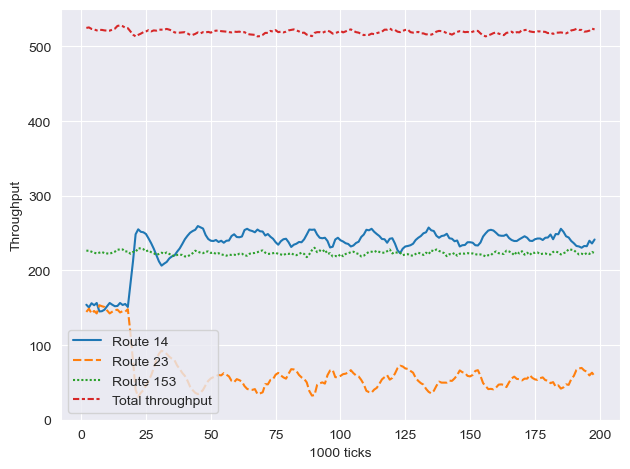

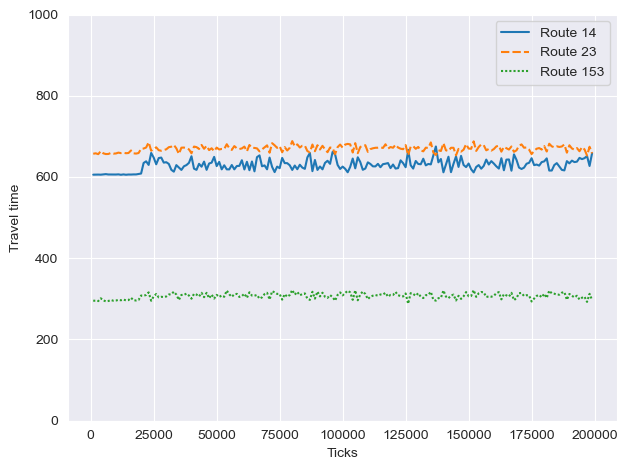

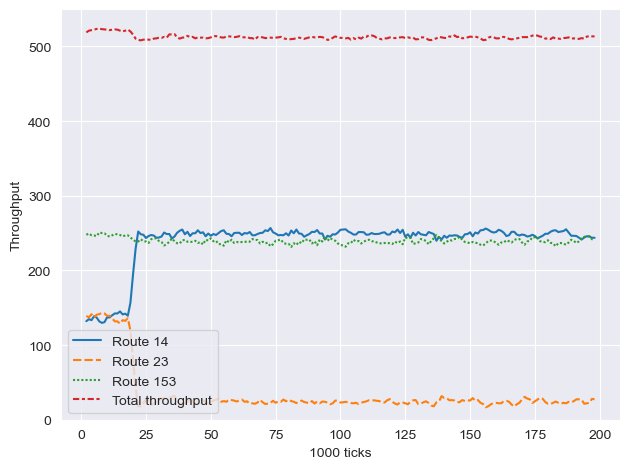

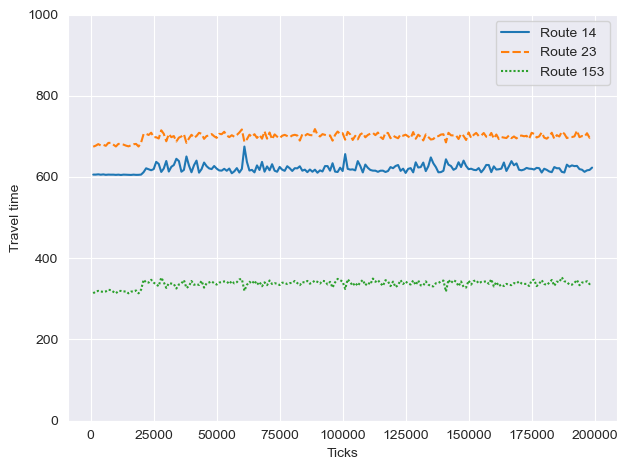

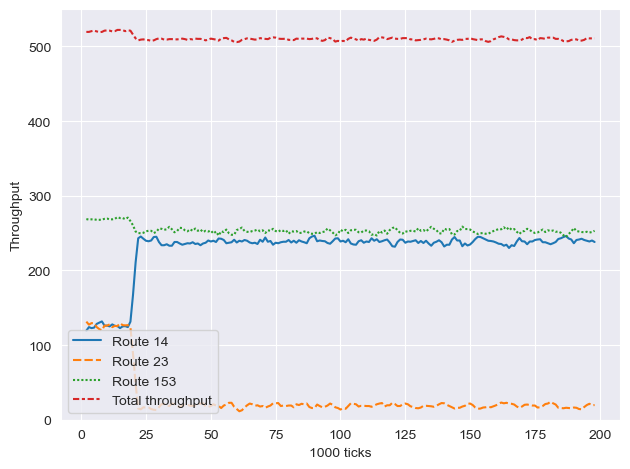

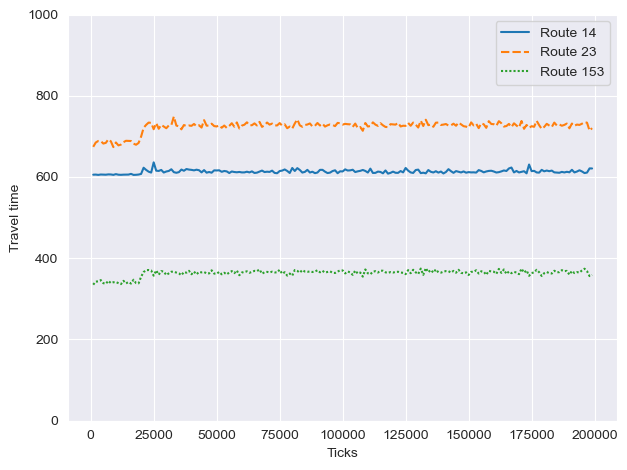

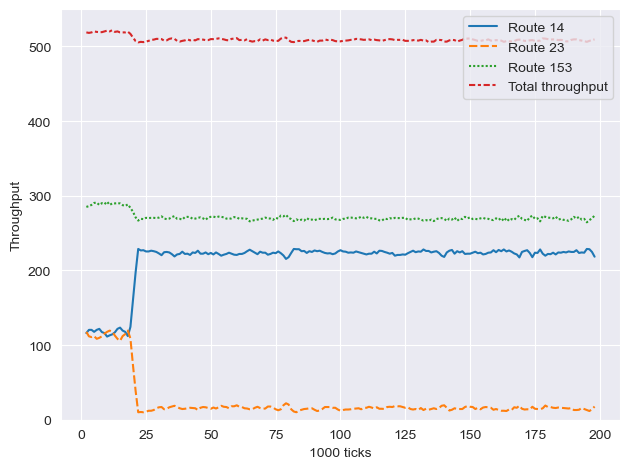

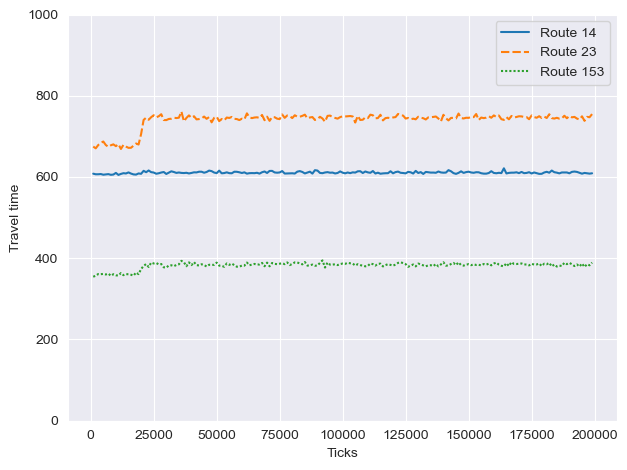

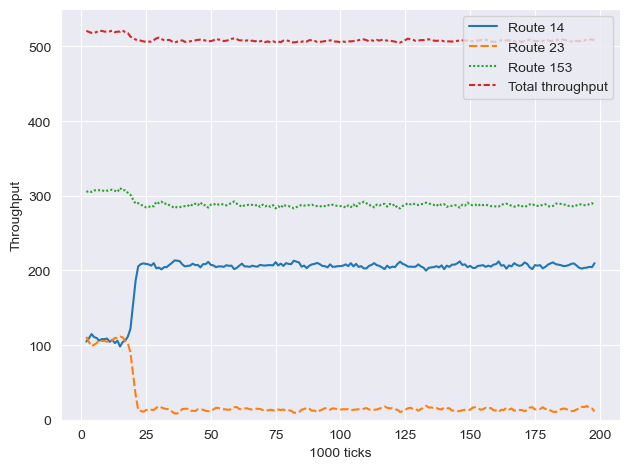

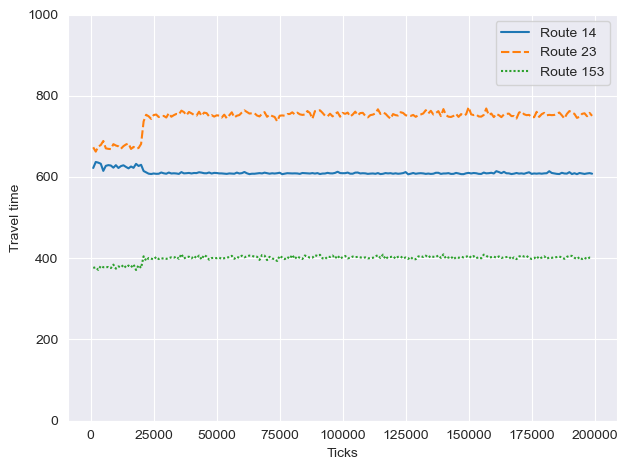

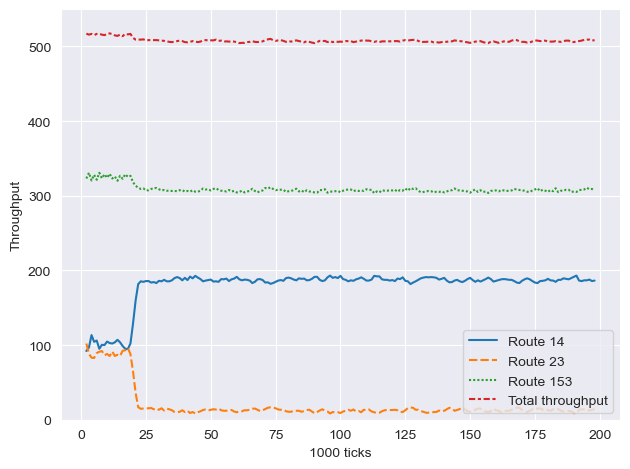

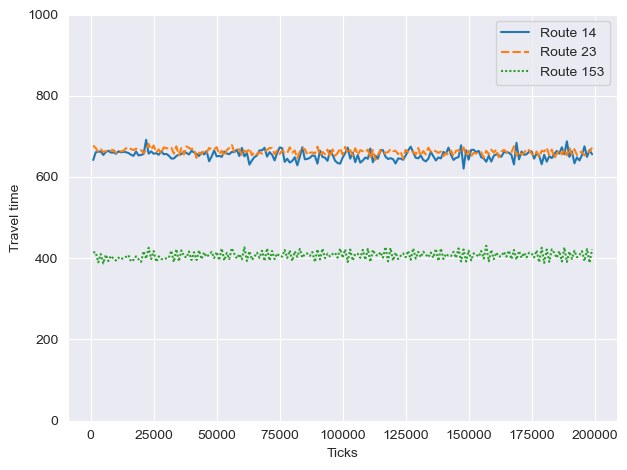

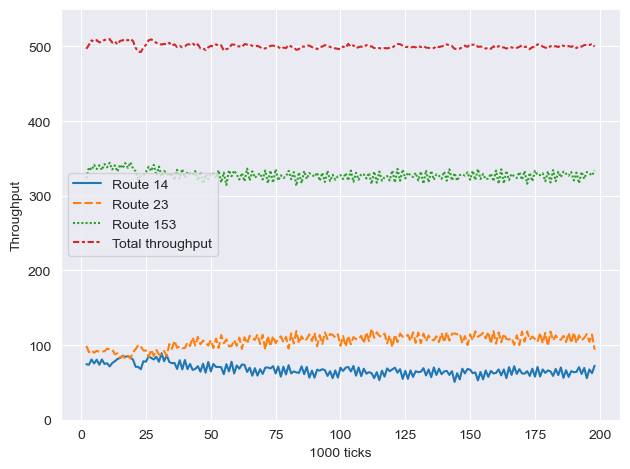

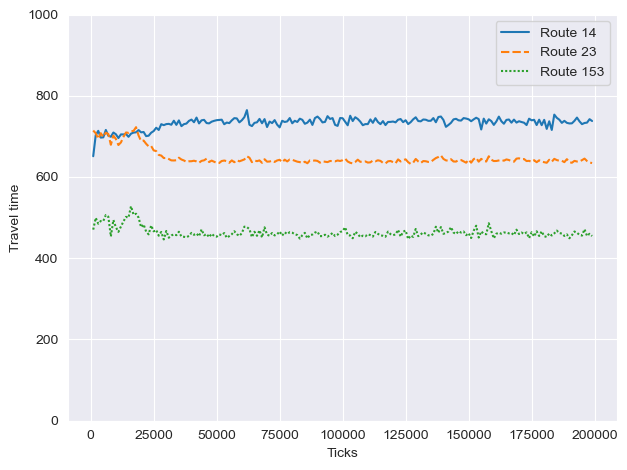

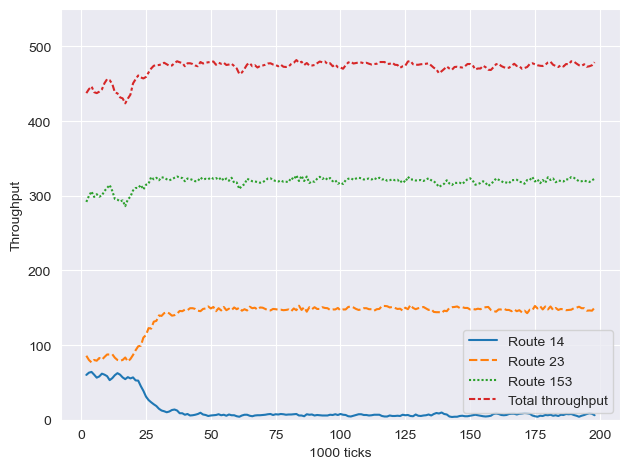

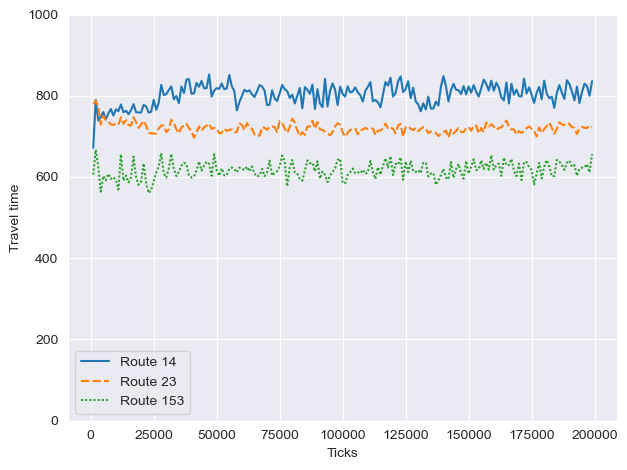

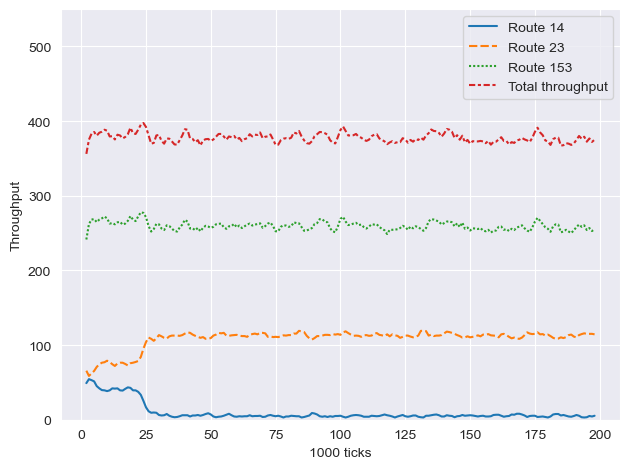

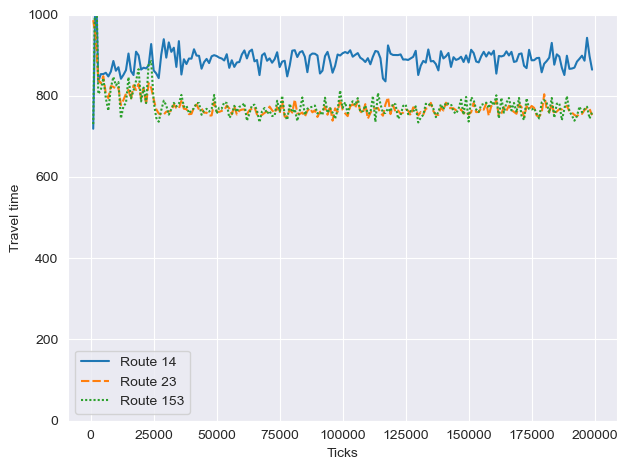

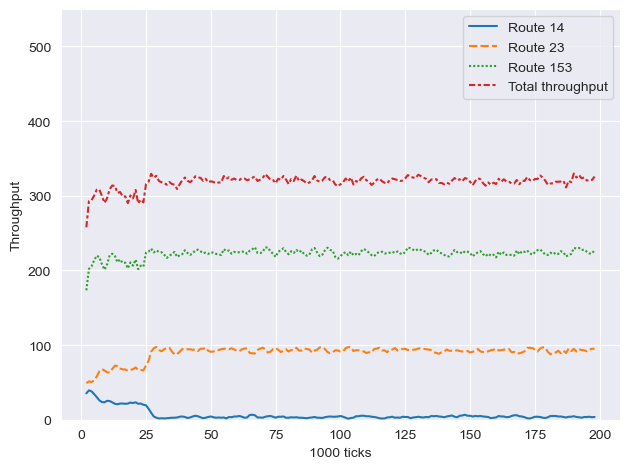

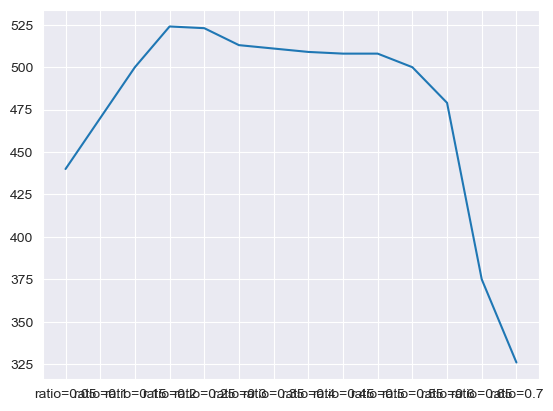

In [38]:
analyse_bus_experiments()

# Run toll-road experiments

In [39]:
toll_costs = [x for x in range(50, 501, 50)]
for toll in toll_costs:
    print(toll)
    if PERFORM_TOLL_EXPERIMENTS:
        toll_model = Model_5link_toll(AGENT_COUNT, toll)
        toll_model.initialize_agents_positions()

        for _ in range(EXPERIMENT_STEPS):
            toll_model.step()

        save_toll_experiments([toll_model], [f"{toll=}"])

50
100
150
200
250
300
350
400
450
500


loaded models
toll=0
we found that
 - 58 agents took route R14 and R153
 - 189 agents took route R14 and R153 and R23
 - 1 agents took route R14 and R23
in their last 30 passes through the network

Total occurrences:  {'R153': 5224, 'R14': 1875, 'R23': 341}
Averages:  {'R153': 650, 'R14': 733, 'R23': 816}

toll=50
we found that
 - 82 agents took route R14 and R153
 - 166 agents took route R14 and R153 and R23
in their last 30 passes through the network

Total occurrences:  {'R14': 1954, 'R153': 5211, 'R23': 275}
Averages:  {'R14': 710, 'R153': 599, 'R23': 797}

toll=100
we found that
 - 162 agents took route R14 and R153 and R23
 - 86 agents took route R14 and R153
in their last 30 passes through the network

Total occurrences:  {'R153': 5178, 'R14': 2000, 'R23': 262}
Averages:  {'R153': 544, 'R14': 686, 'R23': 770}

toll=150
we found that
 - 157 agents took route R14 and R153 and R23
 - 91 agents took route R14 and R153
in their last 30 passes through the network

Total occurrences:  

/Users/rickhuizing/PycharmProjects/DMAS/dmas_braess/plot_utils.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


we found that
 - 134 agents took route R14 and R153 and R23
 - 20 agents took route R14 and R153
 - 19 agents took route R153 and R23
 - 67 agents took route R14 and R23
 - 4 agents took route R23
 - 4 agents took route R14
in their last 30 passes through the network

Total occurrences:  {'R14': 4116, 'R23': 3059, 'R153': 265}
Averages:  {'R14': 603, 'R23': 604, 'R153': 242}

[{'R153': 650, 'R14': 733, 'R23': 816}, {'R14': 710, 'R153': 599, 'R23': 797}, {'R153': 544, 'R14': 686, 'R23': 770}, {'R153': 487, 'R14': 663, 'R23': 744}, {'R153': 407, 'R14': 610, 'R23': 733}, {'R14': 614, 'R23': 721, 'R153': 362}, {'R14': 624, 'R23': 683, 'R153': 325}, {'R153': 265, 'R23': 626, 'R14': 615}, {'R14': 603, 'R23': 603, 'R153': 242}, {'R14': 604, 'R23': 604, 'R153': 242}, {'R14': 603, 'R23': 604, 'R153': 242}]
          &       0       &      50       &      100      &      150      &      200      &      250      &      300      &      350      &      400      &      450      &      500      
Rout

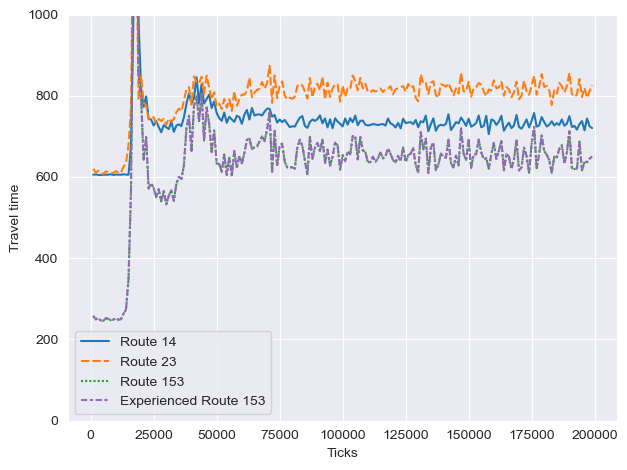

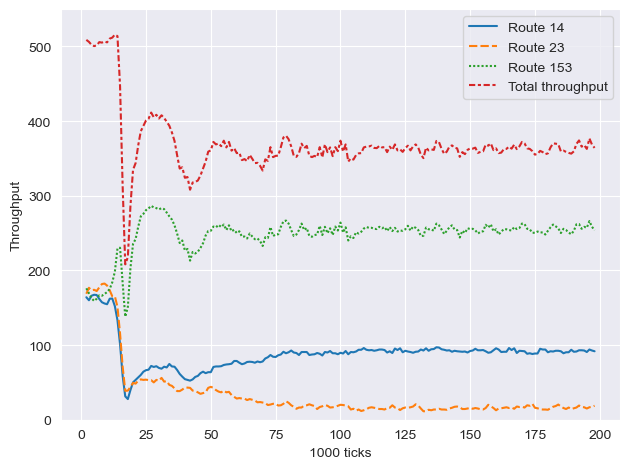

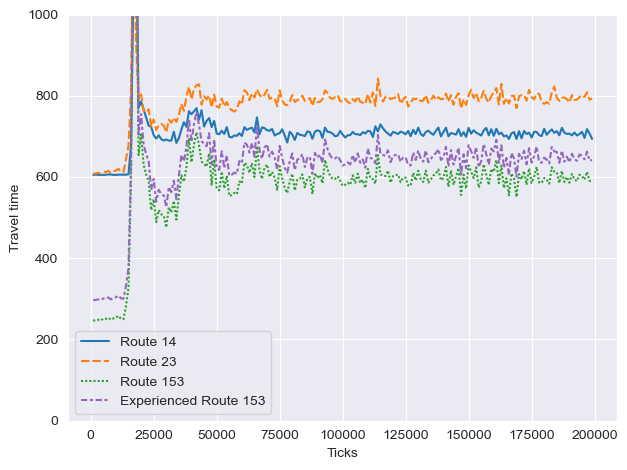

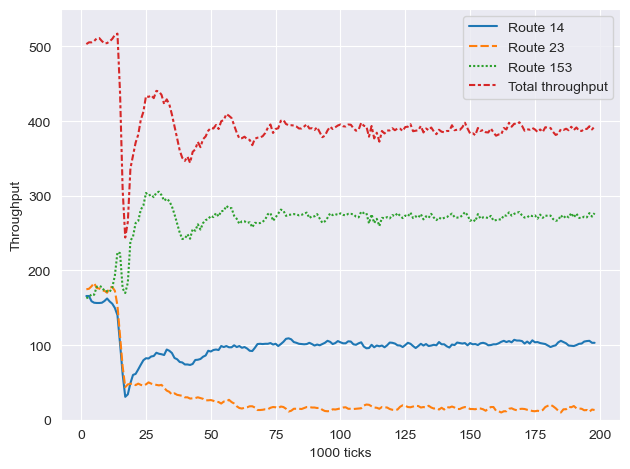

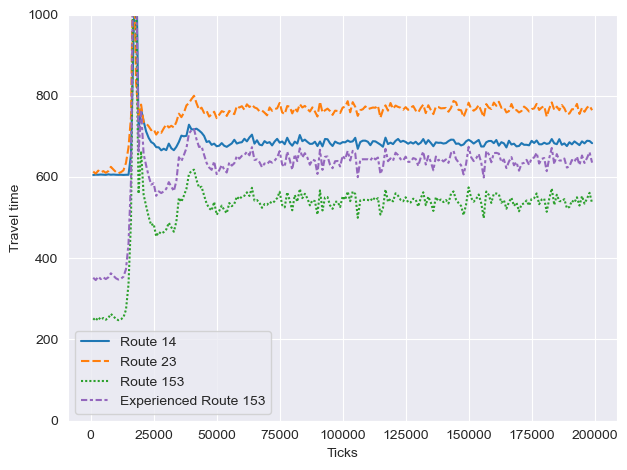

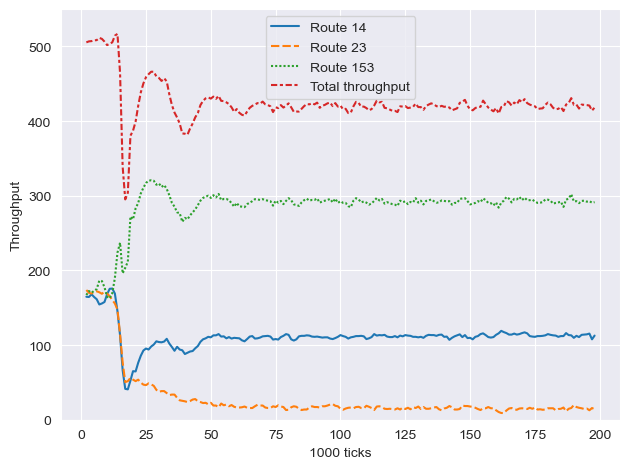

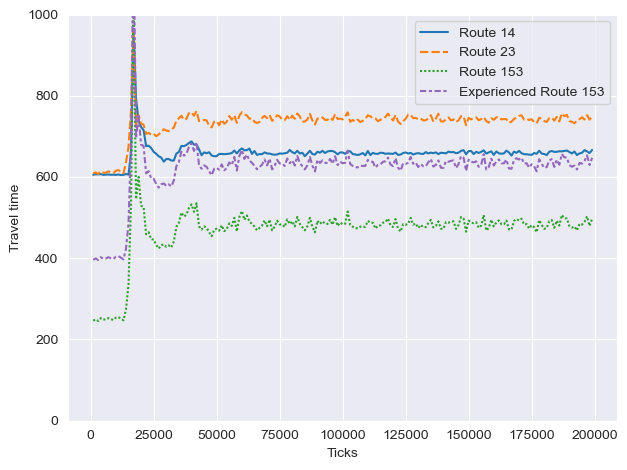

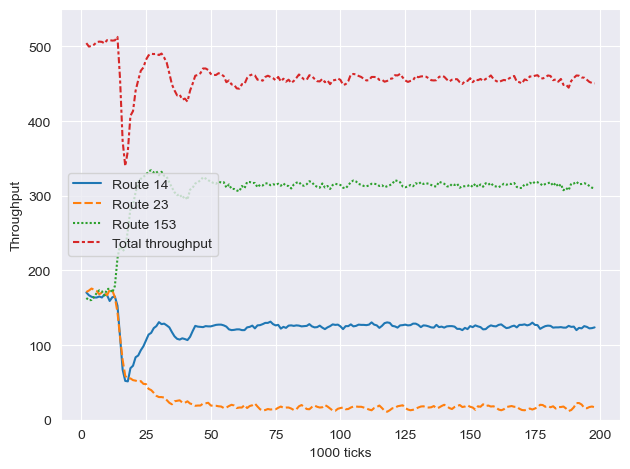

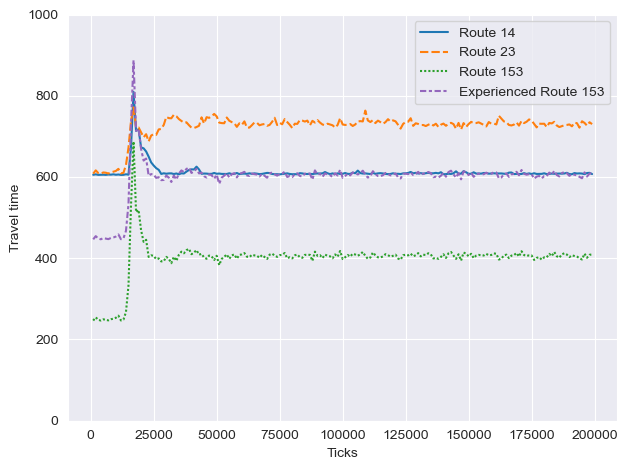

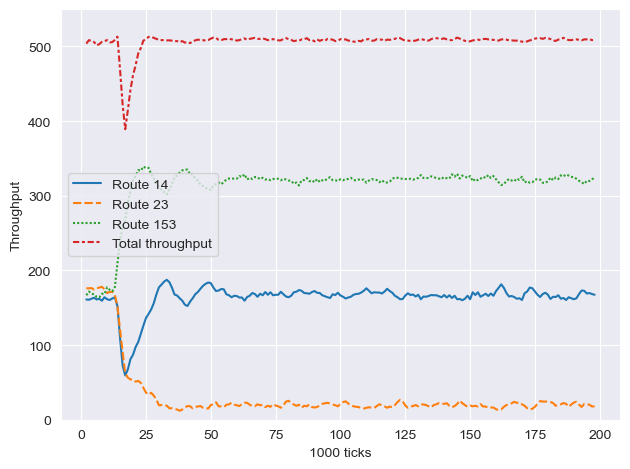

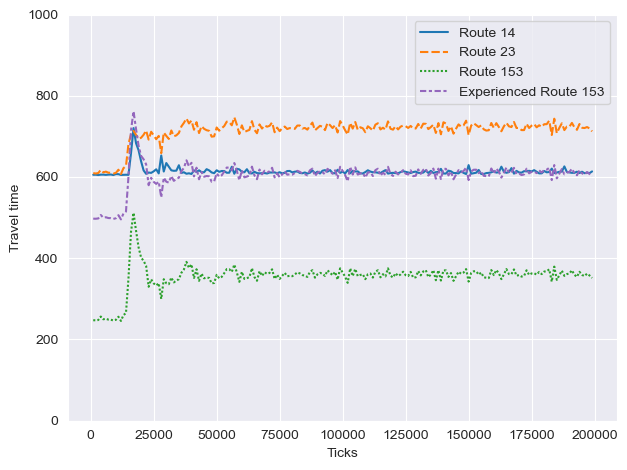

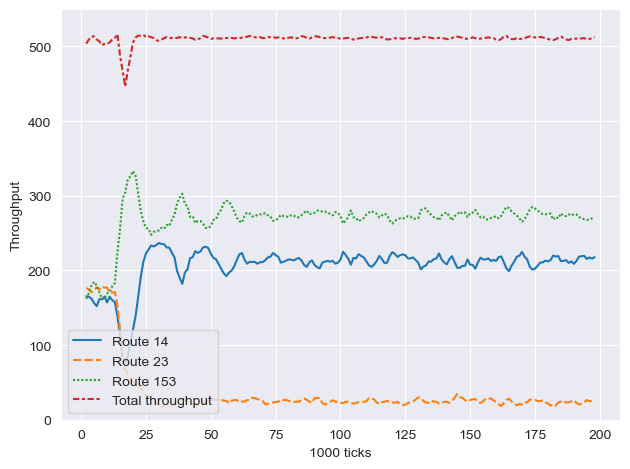

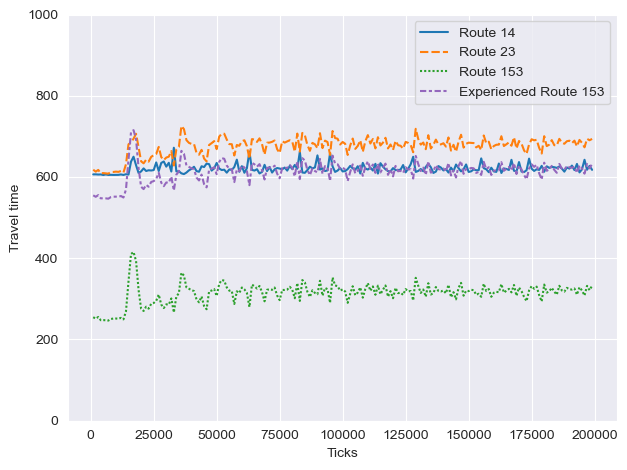

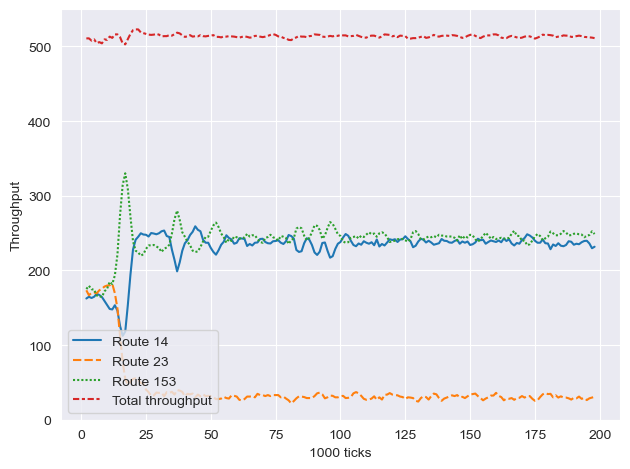

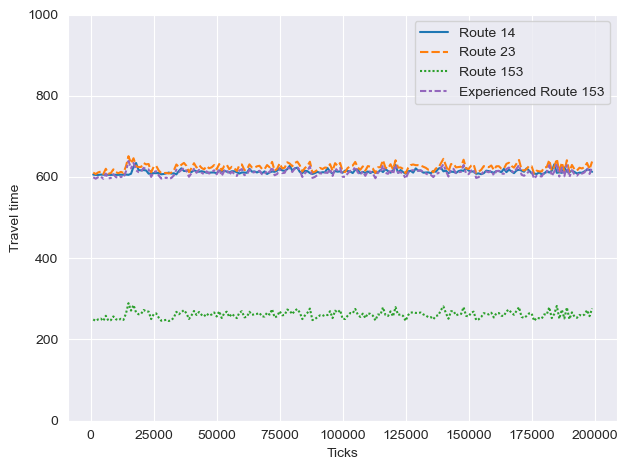

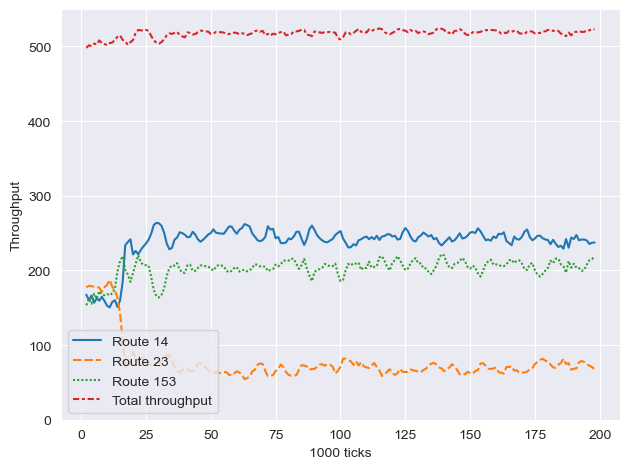

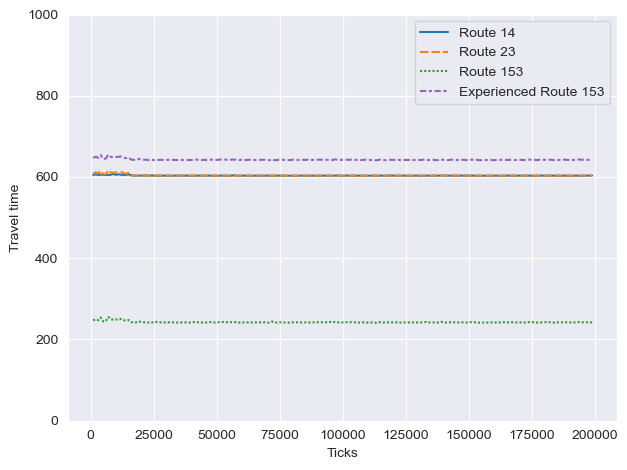

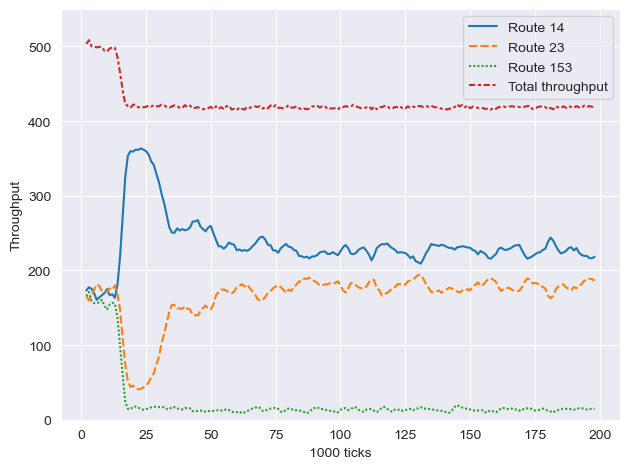

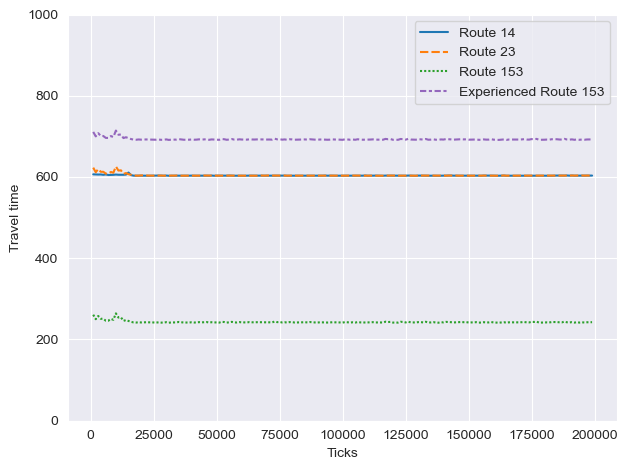

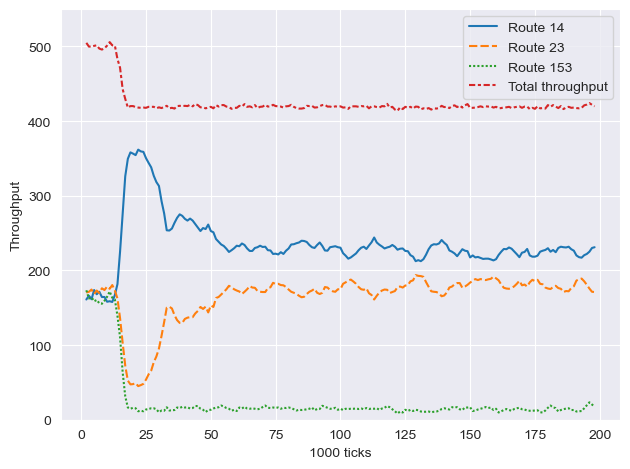

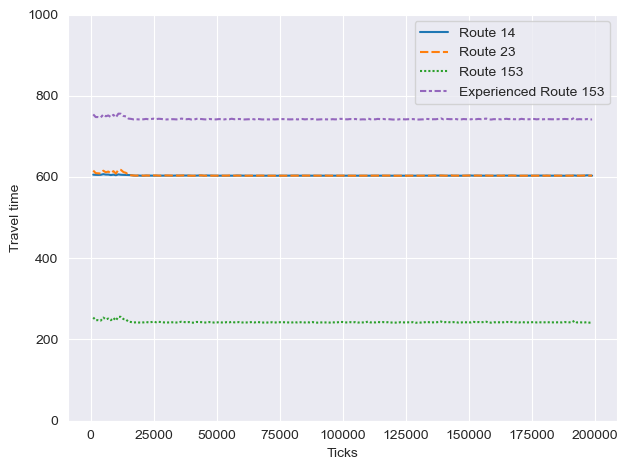

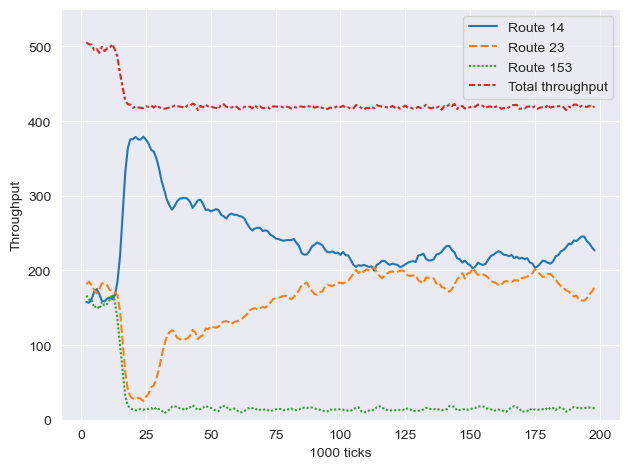

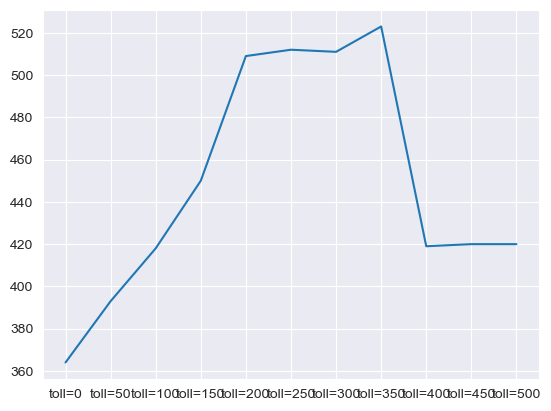

In [40]:
analyse_toll_experiments()

In [52]:
throughput = get_average_throughput(model_5link_results)
print(throughput.iloc[-1])

counter_R14          94.333333
counter_R23          15.000000
counter_R153        251.000000
total throughput    360.333333
Name: 198, dtype: float64


In [54]:
bus_data = load_toll_experiments()

for key, value in bus_data.items():
    print(key)
    experiment_data, experiment_history = value
    throughput = get_average_throughput(experiment_data)
    print(throughput.iloc[-1])

loaded models
toll=0
counter_R14          91.666667
counter_R23          18.666667
counter_R153        253.666667
total throughput    364.000000
Name: 198, dtype: float64
toll=50
counter_R14         103.000000
counter_R23          13.000000
counter_R153        276.666667
total throughput    392.666667
Name: 198, dtype: float64
toll=100
counter_R14         112.666667
counter_R23          14.000000
counter_R153        291.333333
total throughput    418.000000
Name: 198, dtype: float64
toll=150
counter_R14         123.666667
counter_R23          16.666667
counter_R153        310.000000
total throughput    450.333333
Name: 198, dtype: float64
toll=200
counter_R14         167.333333
counter_R23          18.000000
counter_R153        323.333333
total throughput    508.666667
Name: 198, dtype: float64
toll=250
counter_R14         217.666667
counter_R23          24.000000
counter_R153        270.666667
total throughput    512.333333
Name: 198, dtype: float64
toll=300
counter_R14         231.66